### Import required libraries

In [1]:
import PIL
import os
import csv

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical
from pathlib import Path
from PIL import Image

### Define const values

In [2]:
batch_size = 32
img_size = 256
datadir = 'dataset/'

train_set_size = 1

categories = [
    "loop_scattering",
    "background_ring",
    "strong_background",
    "diffuse_scattering",
    "artifact",
    "ice_ring",
    "non_uniform_detector"
]

# categories = [
#     "loop_scattering"
# ]

conv_2d_size = 3
conv_2d_activation = 'relu'
pooling_2d_size = 5
loss = 'binary_crossentropy'
batch_size = 300                            # Ilość obrazów wrzucanych jednorarazowo do sieci
epochs = 14
dense_units = 128
acceptation_threshold = 0.5

### Load images meta

In [3]:
IMAGES_META = {}
TEST_DATA_ORDER = []

def num_to_bool(text):
    if text == "0":
        return 0.
    else:
        return 1.

with open('train.csv', newline='') as csvfile:
    csvreader = csv.DictReader(csvfile)
    
    for row in csvreader:
        image_categories = []
        
        for category in categories:
            image_categories.append(num_to_bool(row[category]))
            
        IMAGES_META[row["image"]] = image_categories

with open('test.csv', newline='') as csvfile:
    csvreader = csv.DictReader(csvfile)
    
    for row in csvreader:
        TEST_DATA_ORDER.append(row["image"])


### Load images

In [4]:
IMAGES = []
LABELS = []

COMPETITION_IMAGES = []
COMPETITION_IMAGES_NAMES = []


for img in os.listdir(datadir):
    image = Image.open(datadir + img).convert("L")

    ii = image.resize((img_size,img_size), Image.BICUBIC)
    arr = np.asarray(ii)  / 255.0
    
    anomalies = IMAGES_META.get(img.replace(".png", ""))
    
    if anomalies == None:
        # Zdjęcie nie należy do zbioru testowego
        COMPETITION_IMAGES.append(arr)
        COMPETITION_IMAGES_NAMES.append(img.replace(".png", ""))
        continue

    IMAGES.append(arr)
    LABELS.append(anomalies)
    
IMAGES = np.array(IMAGES)
COMPETITION_IMAGES = np.array(COMPETITION_IMAGES)
IMAGES = IMAGES.reshape(len(IMAGES), img_size, img_size, 1)
COMPETITION_IMAGES = COMPETITION_IMAGES.reshape(len(COMPETITION_IMAGES), img_size, img_size, 1)
LABELS = np.array(LABELS)

print("Images shape: ", IMAGES.shape)

Images shape:  (5048, 256, 256, 1)


### Show image and classification

Anomalies:  [0. 0. 1. 0. 0. 1. 0.]


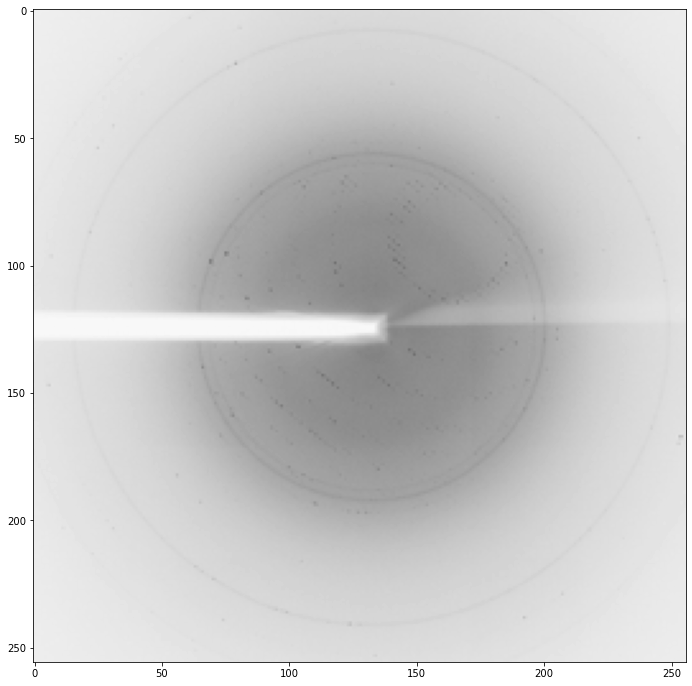

In [5]:
plt.figure(figsize=(12,12))
image_num = 6
plt.imshow(IMAGES[image_num], cmap='gray', vmin=0, vmax=1)
print("Anomalies: ", LABELS[image_num])

#### Parametry sieci neuronowej

In [6]:
model = Sequential()

model.add(Conv2D(32, (conv_2d_size, conv_2d_size), input_shape = (img_size, img_size, 1), activation = conv_2d_activation)) # input shape -> bardzo wazne zeby odpowiadalo wymiarowi obrazkow - tutaj np. obrazki 64x64 i 3 kanały
model.add(MaxPooling2D(pool_size = (pooling_2d_size, pooling_2d_size)))

model.add(Conv2D(32, (conv_2d_size, conv_2d_size), activation = conv_2d_activation))
model.add(MaxPooling2D(pool_size = (pooling_2d_size, pooling_2d_size)))

model.add(Flatten())

model.add(Dense(units = dense_units, activation = 'sigmoid'))
model.add(Dense(units = len(categories), activation = 'sigmoid'))

In [7]:
model.compile(
    loss = loss,
    optimizer = 'Adam',
    metrics = ['accuracy']
)

In [8]:
# Podzielenie na grupy
train_images_count = int(len(IMAGES) * train_set_size)
test_images_count = len(IMAGES) - train_images_count

IMAGES_TRAIN = IMAGES[:train_images_count]
LABELS_TRAIN = LABELS[:train_images_count]
IMAGES_TEST = IMAGES[train_images_count:]
LABELS_TEST = LABELS[train_images_count:]

In [9]:
hist = model.fit(
    IMAGES_TRAIN,
    LABELS_TRAIN,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.1
)

Epoch 1/14
16/16 [==============================] - 44s 3s/step - loss: 0.5728 - accuracy: 0.2809 - val_loss: 0.4816 - val_accuracy: 0.5723
Epoch 2/14
16/16 [==============================] - 44s 3s/step - loss: 0.5304 - accuracy: 0.3344 - val_loss: 0.4667 - val_accuracy: 0.5901
Epoch 3/14
16/16 [==============================] - 43s 3s/step - loss: 0.4995 - accuracy: 0.3326 - val_loss: 0.4292 - val_accuracy: 0.5663
Epoch 4/14
16/16 [==============================] - 44s 3s/step - loss: 0.4670 - accuracy: 0.3251 - val_loss: 0.4052 - val_accuracy: 0.5307
Epoch 5/14
16/16 [==============================] - 44s 3s/step - loss: 0.4455 - accuracy: 0.3553 - val_loss: 0.3896 - val_accuracy: 0.5465
Epoch 6/14
16/16 [==============================] - 45s 3s/step - loss: 0.4357 - accuracy: 0.3867 - val_loss: 0.3870 - val_accuracy: 0.5762
Epoch 7/14
16/16 [==============================] - 44s 3s/step - loss: 0.4255 - accuracy: 0.3993 - val_loss: 0.3652 - val_accuracy: 0.5723
Epoch 8/14
16/16 [==

In [10]:
model.save('lastmodel')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: lastmodel\assets


In [11]:
# Evaluate
if test_images_count > 0:
    model.evaluate(IMAGES_TEST, LABELS_TEST)

In [12]:
if test_images_count > 0:
    hamming_loss = 0
    total_labels = len(IMAGES_TEST) * len(LABELS_TEST[0])

    def xor_sum(N, L):
        total = 0

        for x in range(len(N)):
            if N[x] != L[x]:
                total += 1

        return total

    total = 0

    categories_results = [0 for x in range(len(categories))]
    categories_false_positive = [0 for x in range(len(categories))]
    categories_true_negetive = [0 for x in range(len(categories))]
    predictions = model.predict(IMAGES_TEST)

    for num in range(len(IMAGES_TEST)):

        prediction = predictions[num]
        
        for x in range(len(prediction)):
            if prediction[x] > acceptation_threshold:
                prediction[x] = 1
            else:
                prediction[x] = 0

        valid = [round(x) for x in LABELS_TEST[num]]

        total += xor_sum(valid, prediction)

        for identifier, (valid_response, predicted_response) in enumerate(zip(valid, prediction)):
            
            if predicted_response == 1 and valid_response == 0:
                categories_false_positive[identifier] += 1
            elif predicted_response == 0 and valid_response == 1:
                categories_true_negetive[identifier] += 1
                
            if valid_response == predicted_response:
                categories_results[identifier] += 1

    categories_results = [x / len(IMAGES_TEST) for x in categories_results]

In [13]:
print("- Convolution 2D size: ", conv_2d_size)
print("- Convolution 2D activation: ", conv_2d_activation)
print("- Pooling 2D size: ", pooling_2d_size)
print("- Loss function: ", loss)
print("- Batch size: ", batch_size)
print("- Epochs: ", epochs)
print("- Dense units: ", dense_units)

- Convolution 2D size:  3
- Convolution 2D activation:  relu
- Pooling 2D size:  5
- Loss function:  binary_crossentropy
- Batch size:  300
- Epochs:  14
- Dense units:  128


In [14]:
print("hamming_loss =", total / total_labels)
print("categories_results =", categories_results)
print("categories_false_positives =", categories_false_positive)
print("categories_true_negatives =", categories_true_negetive)
print("loss =", hist.history["loss"])
print("val_loss =", hist.history["val_loss"])
print("accuracy =", hist.history["accuracy"])
print("val_accuracy =", hist.history["val_accuracy"])
print("categories =", categories)

NameError: name 'total' is not defined

# Generowanie wyników do csv

In [15]:
row_num = 0
unordered_data = {}
predictions = model.predict(COMPETITION_IMAGES)

for image_num in range(len(COMPETITION_IMAGES)):
        prediction = predictions[image_num]
        int_predictions = []

        for x in range(len(prediction)):
            if prediction[x] > acceptation_threshold:
                int_predictions.append(1)
            else:
                int_predictions.append(0)
            
        for annomaly_num, annomaly in enumerate(categories):
            if unordered_data.get(COMPETITION_IMAGES_NAMES[image_num]) is None:
                unordered_data[COMPETITION_IMAGES_NAMES[image_num]] = []
            
            unordered_data[COMPETITION_IMAGES_NAMES[image_num]].append(
                {
                    'id': row_num,
                    'image': COMPETITION_IMAGES_NAMES[image_num],
                    'anomaly': annomaly,
                    'predicted': int_predictions[annomaly_num]
                })
            row_num += 1            

In [16]:
row_num = 1
with open('submission.csv', 'w', newline='') as csvfile:
    spamwriter = csv.DictWriter(csvfile, fieldnames=["id","image","anomaly","predicted"])
    spamwriter.writeheader()
    
    for image_name in TEST_DATA_ORDER:
        for result_row in unordered_data[image_name]:
            result_row["id"] = row_num
            spamwriter.writerow(result_row)
            row_num += 1